In [ ]:
conda create --name simpletuner python=3.12 ipykernel -y 
conda activate simpletuner


# for scripy
apt-get update && apt-get install -y gfortran  
apt-get update && apt-get install -y \
  pkg-config \
  cmake \
  libopenblas-dev \
  liblapack-dev

# manually install torch 2.6
pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu126


# patched to remove some old deps; then install reqs
pip install -r requirements.txt

In [ ]:
# fix triton
pip install --force-reinstall -v "triton==3.1.0"

pip install sentencepiece

# (torch 2.6.0+cu126 requires triton==3.2.0; platform_system == "Linux" and platform_machine == "x86_64", but you have triton 3.1.0 which is incompatible.)

get some data:

In [1]:
!export CUDA_VISIBLE_DEVICES=1

In [ ]:
# !wget https://huggingface.co/b74444/style1/resolve/main/base.zip
# !unzip /local/yada/apps/SimpleTuner-a/notebooks/base.zip
# !wget https://huggingface.co/b74444/style1/resolve/main/dark%20and%20bright.zip
# !unzip "dark and bright.zip"

get tagging:

In [1]:
from procslib import get_model, get_model_keys
model = get_model("wdv3_tagger_timm")

Failed to load anime_aesthetic.AnimeAestheticInference: No module named 'pytorch_lightning'
Using global temporary directory: /tmp/unibox_temp
Failed to load complexity_ic9600.IC9600Inference: No module named 'pytorch_lightning'
Failed to load cv2_wrapper.OpenCVMetricsInference: No module named 'skimage'
Failed to load pixiv_compound_score.PixivCompoundScoreInference: No module named 'pytorch_lightning'
Failed to load siglip_aesthetics.SiglipAestheticInference: No module named 'aesthetic_predictor_v2_5'


In [ ]:
import unibox as ub
imgs = ub.ls("/local/yada/apps/SimpleTuner-a/data/b74444", ub.IMG_FILES)

tags = model.infer_many(imgs)

2025-04-13 20:06:45 [INFO] ls: Listing contents of /local/yada/apps/SimpleTuner-a/data/b74444


Listing local files: 0files [00:00, ?files/s]

Inferring tags:   0%|          | 0/28 [00:00<?, ?it/s]

In [6]:
import os

PREFIX = "an anime illustration of "

for _, row in tags.iterrows():
    _caption = row["caption"]
    _path = row["path"]

    _caption = PREFIX + _caption

    txt_path = os.path.splitext(_path)[0] + ".txt"
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(_caption)

In [9]:
tags["taglist"].iloc[0]

'2girls, multiple girls, yuri, long hair, blonde hair, kimono, food, japanese clothes, candy apple, black hair, fireworks, short hair, floral print, red eyes, hair ribbon, blue kimono, closed eyes, ribbon, red ribbon, outdoors, hair ornament, blush, print kimono, one side up, imminent kiss, long sleeves, sash, open mouth, obi, yukata, upper body, shared food, flower, hair flower, pink kimono, signature, night, sidelocks, looking at another, sky, feeding, wide sleeves, nishikigi chisato, inoue takina'

training:

see https://github.com/arot-devs/SimpleTuner-a/blob/main/documentation/quickstart/HIDREAM.md


to fix `The expanded size of the tensor (4096) must match the existing size ...`: set "crop" to `true` in `hidream/multidatabackend.json`

To fix "config different from datset": remove the json inside dataset folder: 
- `rm ./data/b74444/aspect_ratio_bucket_indices_dreambooth-subject.json`


to use multi gpu: set env:

```
TRAINING_NUM_PROCESSES=4
TRAINING_DYNAMO_BACKEND=inductor
```


also need flash attn for torch compile:  (doesnt work for now)
```
pip install flash-attn --no-build-isolation
```

## training:


bs4: 40G

bs12: 72/79G  

## using model:

train kinda failed but use lora to see

In [2]:
%cd ..

/local/yada/apps/SimpleTuner-a


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


  0%|          | 0/30 [00:00<?, ?it/s]

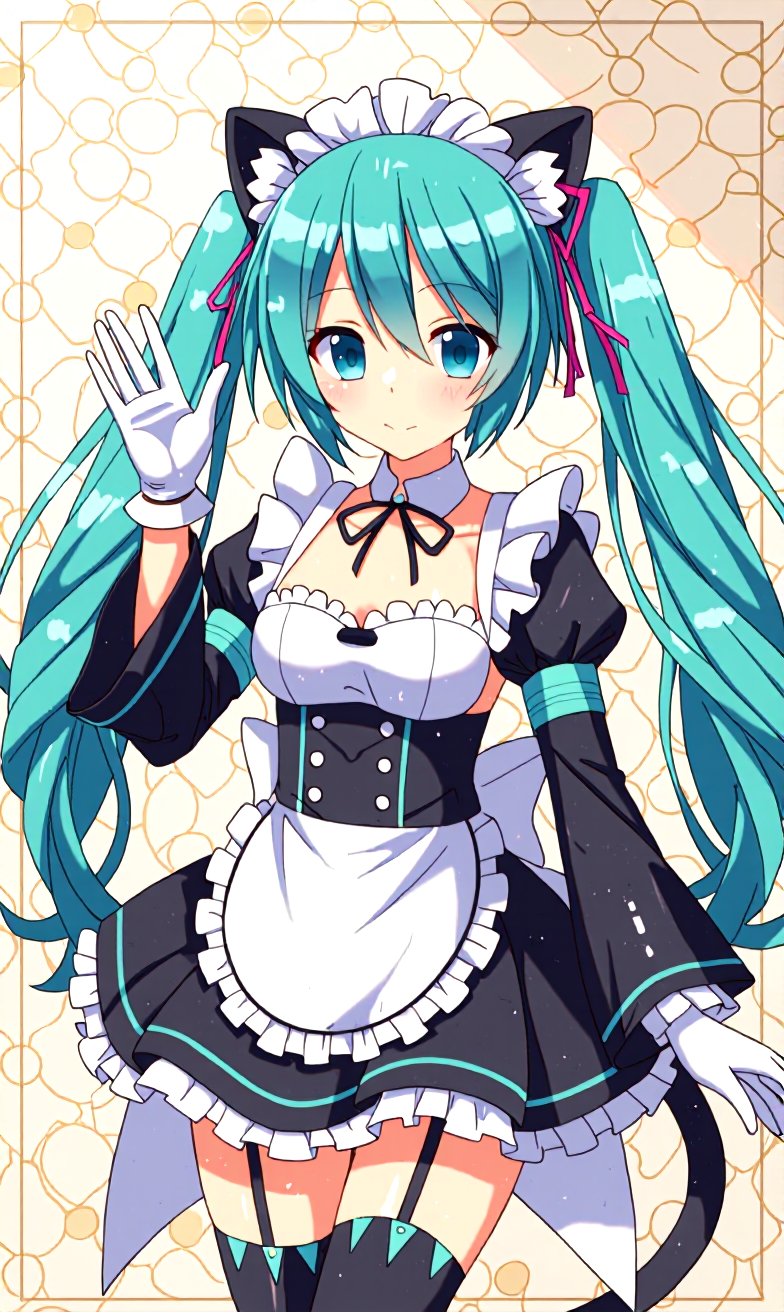

In [ ]:
import gradio as gr
import torch
from PIL import Image
import os
import time
import hashlib
import json
import random

# Make sure the output directory exists
os.makedirs("output", exist_ok=True)

def generate_catmaid(prompt, negative_prompt, width, height, seed=-1):

    if seed == -1:
        seed = random.randint(0, 2**32 - 1)

    # Encode the prompts
    t5_embeds, llama_embeds, negative_t5_embeds, negative_llama_embeds, pooled_embeds, negative_pooled_embeds = pipeline.encode_prompt(
        prompt=prompt,
        prompt_2=prompt,
        prompt_3=prompt,
        prompt_4=prompt,
        num_images_per_prompt=1
    )

    # Generate the image
    model_output = pipeline(
        t5_prompt_embeds=t5_embeds,
        llama_prompt_embeds=llama_embeds,
        pooled_prompt_embeds=pooled_embeds,
        negative_t5_prompt_embeds=negative_t5_embeds,
        negative_llama_prompt_embeds=negative_llama_embeds,
        negative_pooled_prompt_embeds=negative_pooled_embeds,
        num_inference_steps=30,
        generator=torch.Generator(
            device='cuda' if torch.cuda.is_available() else 
                   'mps' if torch.backends.mps.is_available() else 'cpu'
        ).manual_seed(seed),
        width=width,
        height=height,
        guidance_scale=3.2,
    ).images[0]

    # Prepare timestamp and hash for unique filename
    timestamp = int(time.time())
    hash_input = f"{prompt}{negative_prompt}{timestamp}{width}{height}".encode()
    image_hash = hashlib.sha256(hash_input).hexdigest()[:10]
    filename_base = f"{timestamp}_{image_hash}"

    image_path = f"output/{filename_base}.png"
    json_path = f"output/{filename_base}.json"

    # Save image
    model_output.save(image_path)

    # Save metadata as JSON
    metadata = {
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "width": width,
        "height": height,
        "timestamp": timestamp,
        "image_path": image_path,
        "seed": seed,
    }

    with open(json_path, "w") as f:
        json.dump(metadata, f, indent=4)

    return model_output

demo = gr.Interface(
    fn=generate_catmaid,
    inputs=[
        gr.Textbox(label="Prompt", value="an anime illustration of hatsune miku, 1girl, white gloves, dress, cat ears, maid outfit, indoors, cat ears", 
                lines=4, interactive=True),
        gr.Textbox(label="Negative Prompt", value="ugly, cropped, blurry, low-quality, mediocre average", lines=2),
        gr.Slider(minimum=256, maximum=1536, step=64, value=768, label="Width"),
        gr.Slider(minimum=256, maximum=1536, step=64, value=1280, label="Height"),
        gr.Slider(minimum=-1, maximum=2**32 - 1, step=1, value=-1, label="Seed"),
    ],
    outputs=gr.Image(label="Generated Image"),
    title="Cat Maid Generator: Monya's Eternal Penance",
    description="Congratulations. You can now mint emotional damage into .png files and store them with metadata."
)

if __name__ == "__main__":
    demo.launch(share=True)


(seems prettybad, large artifacts)

retrain with:
- bf16 (bs6 acc 2*4)
- proper lr handling
- disable torch compile (because eval fails sometimes)